# Quick Start - Mouse Brain

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/blob/main/docs/source/notebooks/quick_start_mouse.ipynb)

In this tutorial, we will use the postnatal mouse brain dataset [(Hochgerner & Zeisel et al 2018)](https://doi.org/10.1038/s41593-017-0056-2) to dissect the metabolic pathways in early development of dentate gyrus. This dataset captures the molecular progression of early neurogenesis and granule cell maturation across P24 and P35. 

## This tutorial includes following steps:
* [Loading libraries](#loading-libraries)
* [Loading mouse brain data](#loading-mouse-brain-data)
* [Run scCellFie](#run-sccellfie)
* [Export results](#export-results)
* [Visualization of results](#visualization-of-results)

## Loading libraries <a class="anchor" id="loading-libraries"></a>

In [1]:
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

import textwrap

## To avoid warnings
import warnings
warnings.filterwarnings("ignore")

## Loading mouse brain data <a class="anchor" id="loading-mouse-brain-data"></a>

The Postnatal Dentate Gyrus dataset contains 2930 cells `(n_obs)` with 13913 genes `(n_vars)`.

This is a processed data including 14 cell type annotations in `.obs['clusters']`, and 22 subclusters of cell type annotations in `.obs['clusters_enlarged']`. For demonstration purpose, this tutorial will use the `.obs['clusters']` cell labels.

In [2]:
adata = sc.read(filename='./data/MusMusculus_DentateGyrus.h5ad', 
                backup_url='https://cell2fate.cog.sanger.ac.uk/DentateGyrus/DentateGyrus_anndata.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 2930 × 13913
    obs: 'clusters', 'age(days)', 'clusters_enlarged'
    uns: 'clusters_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

<div class="alert alert-info">
<b>Note!</b>

As shown in the output, this AnnData also contains raw count matrices of `spliced` (exonic) and `unspliced` (intronic) in `.layers` which are presented explicitly for velocity analysis. 
The `ambiguous` matrix contains reads overlapping exon-intron boundaries. 

Please visit this [10X Analysis Guides](https://www.10xgenomics.com/analysis-guides/trajectory-analysis-using-10x-Genomics-single-cell-gene-expression-data) for the details.

</div>

In this tutorial, we will copy `.layers['spliced']` into the `.X` as raw spliced counts are normally used in gene expression analysis.

In [4]:
adata.X = adata.layers['spliced'].copy()

## Run scCellFie <a class="anchor" id="run-sccellfie"></a>

In current version, scCellFie supports `human` or `mouse` specific metabolic pathways. We will select `organism='mouse'` for the analysis.

In [5]:
results = sccellfie.run_sccellfie_pipeline(adata,
                                           organism='mouse', 
                                           sccellfie_data_folder=None,
                                           n_counts_col=None, # Total counts per cell will be computed if left as None, 
                                           process_by_group=False, # Whether to do the processing by cell groups
                                           groupby=None, # Column indicating cell groups if `process_by_group=True`
                                           neighbors_key='neighbors', # Neighbors information if precomputed. Otherwise, it will be computed here
                                           n_neighbors=10, # Number of neighbors to use
                                           batch_key=None, # there is no batch_key in this dataset 
                                           threshold_key='sccellfie_threshold',  # This is for using the default database. If personalized thresholds are used, specificy column name
                                           smooth_cells=True, # Whether to perform gene expression smoothing before running the tool
                                           alpha=0.33, # Importance of neighbors' expression for the smoothing (0 to 1)
                                           chunk_size=5000, # Number of chunks to run the processing steps (helps with the memory)
                                           disable_pbar=False, 
                                           save_folder=None, # In case results will be saved. If so, results will not be returned and should be loaded from the folder (see sccellfie.io.load_data function
                                           save_filename=None # Name for saving the files, otherwise a default name will be used
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: mouse

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Computing neighbors ----


2025-05-03 18:30:17.564251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746297017.586464     958 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746297017.593308     958 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 18:30:17.616900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 9
Shape of new adata object: (2930, 654)
Number of GPRs: 603
Shape of tasks by genes: (197, 654)
Shape of reactions by genes: (603, 654)
Shape of tasks by reactions: (197, 603)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 2930/2930 [00:23<00:00, 125.80it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 1 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


## Export results <a class="anchor" id="export-results"></a>

In [6]:
results.keys()

dict_keys(['adata', 'gpr_rules', 'task_by_gene', 'rxn_by_gene', 'task_by_rxn', 'rxn_info', 'task_info', 'thresholds', 'organism'])

To access metabolic activities, we need to inspect ``results['adata']``:

- The processed single-cell data is located in the AnnData object ``results['adata']``.
- The reaction activities for each cell are located in the AnnData object ``results['adata'].reactions``.
- The metabolic task activities for each cell are located in the AnnData object ``results['adata'].metabolic_tasks``.

In particular:

- ``results['adata']``: contains gene expression in ``.X``.
- ``results['adata'].layers['gene_scores']``: contains gene scores as in the original CellFie paper.
- ``results['adata'].uns['Rxn-Max-Genes']``: contains determinant genes for each reaction per cell.
- ``results['adata'].reactions``: contains reaction scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.
- ``results['adata'].metabolic_tasks``: contains metabolic task scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.

Other keys in the ``results`` dictionary are associated with the scCellFie database and are already filtered for the elements present
in the dataset (``'gpr_rules'``, ``'task_by_gene'``, ``'rxn_by_gene'``, ``'task_by_rxn'``, ``'rxn_info'``, ``'task_info'``, ``'thresholds'``, ``'organism'``).

### Save single-cell results

We can save our single-cell results contained in the AnnData objects (``results['adata']``) into a specific folder. Here we only need to specify the output folder, and the basename that our AnnData objects will have. This function below saves the expression object (``results['adata']``) and those containing scores for reactions and metabolic tasks (``results['adata'].reactions`` and ``results['adata'].metabolic_tasks``, respectively), as separate files.

In [7]:
sccellfie.io.save_adata(adata=results['adata'], output_directory='./results/', filename='Mouse_DentateGyrus_scCellFie')

./results//Mouse_DentateGyrus_scCellFie.h5ad was correctly saved
./results//Mouse_DentateGyrus_scCellFie_reactions.h5ad was correctly saved
./results//Mouse_DentateGyrus_scCellFie_metabolic_tasks.h5ad was correctly saved


## Visualization of results <a class="anchor" id="visualization-of-results"></a>

scCellFie implements multiple visualizations, sometimes building upon Scanpy functionalities. To showcase these visualizations, we first start defining where to find our cell-type annotations in the dataset, and defining a palette of colors for them.

In [8]:
# Column indicating the cell types in the adata.obs dataframe
cell_group = 'clusters'

In [9]:
# We use glasbey to expand the palette into a larger number of colors
# This is useful when we have many cell types
palette = glasbey.extend_palette('Set2', 
                                 palette_size=max([10, results['adata'].metabolic_tasks.obs[cell_group].unique().shape[0]]))

### UMAPs

We can directly plot the activity of metabolic tasks that we are interested in. In this case, we will pick metabolic tasks that are pertinent to this dataset.

In [10]:
metabolic_tasks = ['Synthesis of GABA', 
                   'Synthesis of thromboxane from arachidonate',
                   'Synthesis of taurine from cysteine',
                   'Serine synthesis',
                  ]

Then, we can visualize these tasks using regular UMAP visualizations.

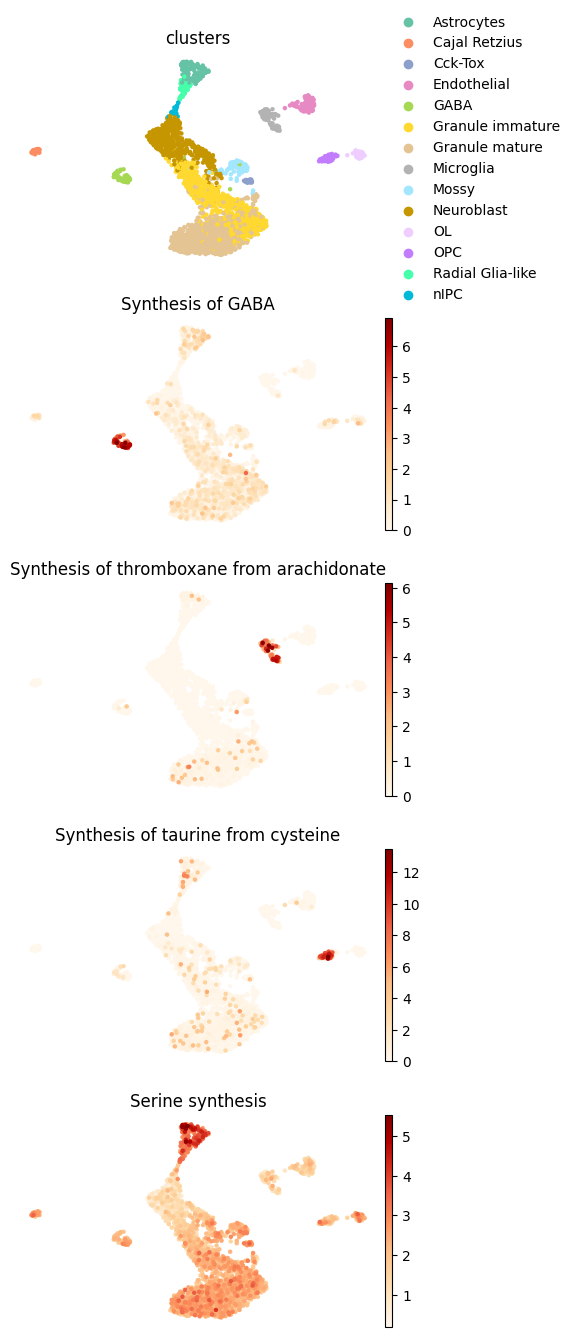

In [11]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[cell_group] + metabolic_tasks,
                ncols=1,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                title=["\n".join(textwrap.wrap(t, width=60)) for t in [cell_group] + metabolic_tasks],
                cmap='OrRd'
               )

### Distribution of metabolic activities across single cells per cell type

We can further inspect the metabolic score distribution across single cells per cell type for these tasks.

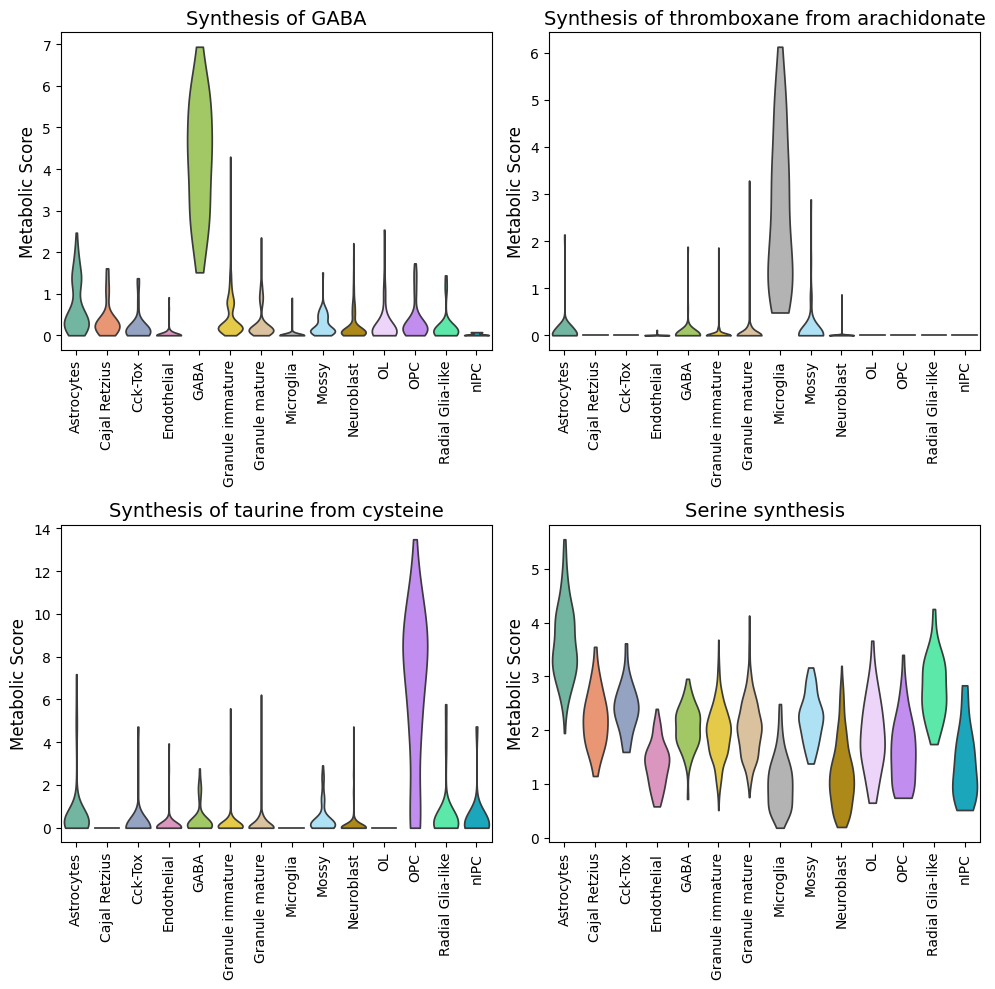

In [12]:
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=metabolic_tasks,
                                                         groupby=cell_group,
                                                         stripplot=False,
                                                         n_cols=2,
                                                         ylabel='Metabolic Score'
                                                        )

Similarly, we can use stacked violin plots. Note that we use ``standard_scale='var'`` to normalize each task by their min and max values. If you prefer visualizing raw scores, remove this parameter.

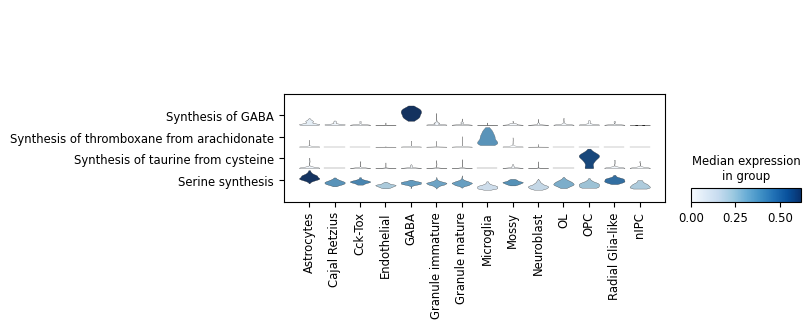

In [13]:
ax = sc.pl.stacked_violin(results['adata'].metabolic_tasks, metabolic_tasks, groupby=cell_group, swap_axes=True, dendrogram=False, standard_scale='var')

### Dot plots

Additionally, we can summarize these activities with the typical dot plot visualizations. Note that we use ``standard_scale='var'`` to normalize each task by their min and max values. If you prefer visualizing raw scores, remove this parameter.

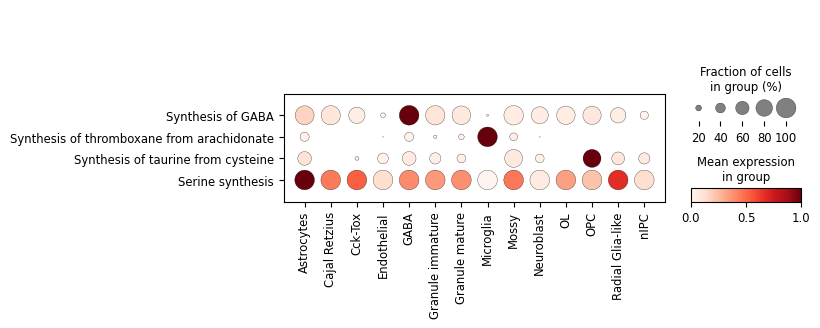

In [14]:
sc.pl.dotplot(results['adata'].metabolic_tasks, var_names=metabolic_tasks, groupby=cell_group, swap_axes=True, standard_scale='var')

### Heatmaps

We can use Scanpy's heatmap to visualize the activity of individual cells per cell type.

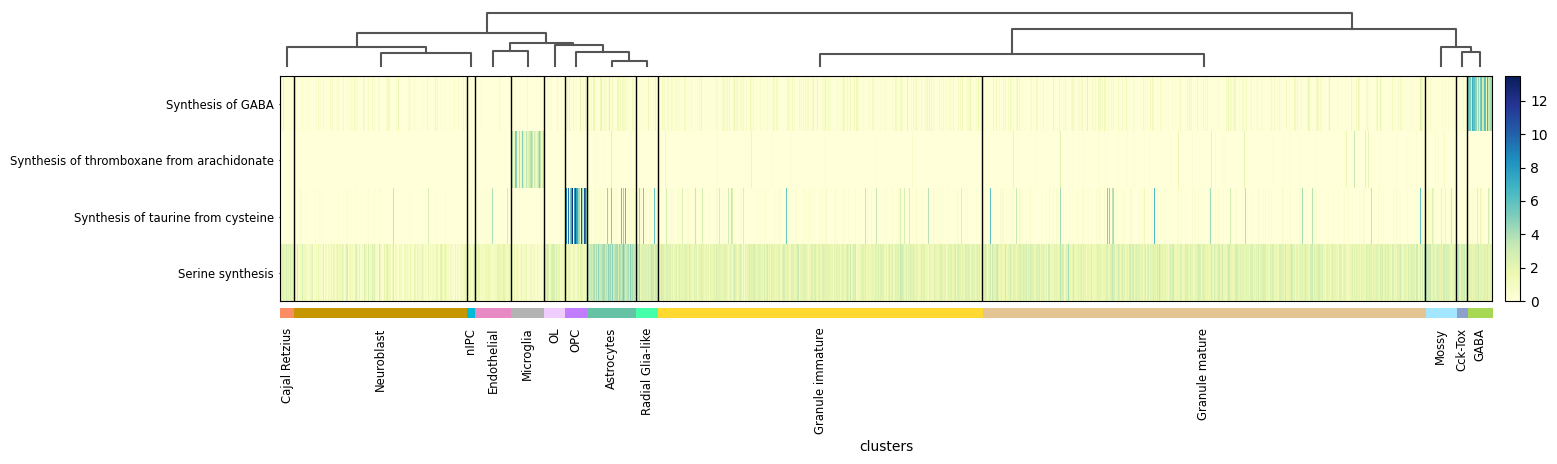

In [15]:
ax = sc.pl.heatmap(results['adata'].metabolic_tasks, var_names=metabolic_tasks, groupby=cell_group, cmap="YlGnBu", swap_axes=True, dendrogram=True,
                   figsize=(16, 4)
                  )

We can also aggregate metabolic activities into a cell-type level, using a central measure that is robust to outliers (Tuckey's trimean).

In [16]:
agg = sccellfie.expression.aggregation.agg_expression_cells(results['adata'].metabolic_tasks, groupby=cell_group, agg_func='trimean')

In [17]:
agg.head()

Task,(R)-3-Hydroxybutanoate synthesis,3'-Phospho-5'-adenylyl sulfate synthesis,AMP salvage from adenine,ATP generation from glucose (hypoxic conditions) - glycolysis,Acetoacetate synthesis,Alanine degradation,Arachidonate degradation,Arachidonate synthesis,Arginine degradation,Aspartate degradation,...,Valine degradation,Valine to succinyl-coA,Vesicle secretion,beta-Alanine degradation,cis-vaccenic acid degradation,cis-vaccenic acid synthesis,gamma-Linolenate degradation,gamma-Linolenate synthesis,glyco-cholate synthesis,tauro-cholate synthesis
Astrocytes,2.215738,0.844881,1.078215,3.025266,2.180813,1.271653,1.173559,1.496051,1.144285,1.272288,...,1.265002,1.021153,0.219967,1.370236,1.097025,1.350242,1.084651,0.040205,0.116810,0.116810
Cajal Retzius,2.152997,0.762255,0.781326,3.233032,2.278572,1.226291,1.332409,1.605646,1.107574,1.223449,...,1.218253,0.700417,0.364217,1.276242,1.245782,1.538652,1.222371,0.003803,0.052228,0.052228
Cck-Tox,2.604648,0.632633,1.476637,4.123826,2.710471,1.091097,1.159861,1.626234,1.000101,1.072762,...,1.083331,0.490523,0.449315,1.130592,1.060528,1.566899,1.065214,0.002493,0.033301,0.033301
Endothelial,1.596339,0.316229,1.305453,2.109409,1.701548,0.802888,1.031869,1.064677,0.717107,0.819215,...,0.805487,0.462138,0.518148,0.805076,0.955358,1.003883,0.955235,0.003446,0.071355,0.071355
GABA,2.415382,0.105530,2.512534,3.490342,2.442147,1.150116,1.228355,1.754267,1.109770,1.148401,...,1.150649,0.500643,0.513985,1.215773,1.116914,1.625362,1.133955,0.023749,0.042844,0.042844


Followed by a min-max normalization to scale values between 0 a 1 per task (Optional).

In [18]:
input_df = sccellfie.preprocessing.matrix_utils.min_max_normalization(agg.T, axis=1)

And use seaborn's function to plot our metabolic tasks

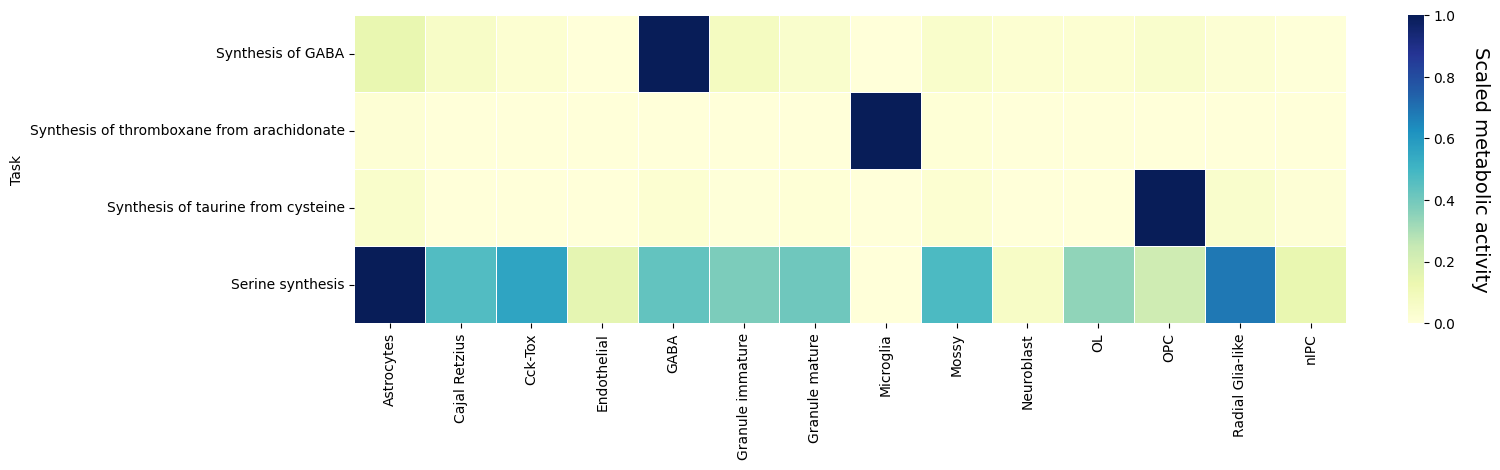

In [19]:
plt.figure(figsize=(16, 4))
g = sns.heatmap(input_df.loc[metabolic_tasks,:], cmap='YlGnBu', linewidths=0.5, xticklabels=1, yticklabels=1)

cbar = g.collections[0].colorbar
cbar.set_label('Scaled metabolic activity', size=14, rotation=270, labelpad=25)  # Change colorbar label size and rotation

# Uncomment code below to save figure
# plt.savefig('./figures/Heatmap-Seaborn.pdf', dpi=300, bbox_inches='tight')

### Track plots

The track plot shows the metabolic activities per single cell represented by height, and colors single cells by their cell-type annotations

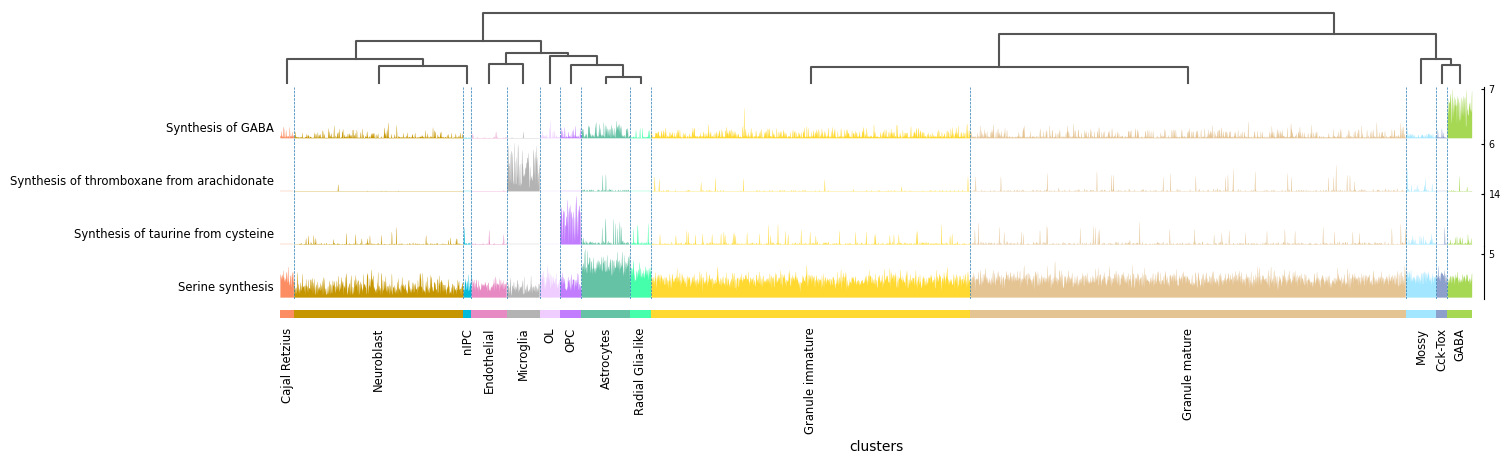

In [20]:
ax = sc.pl.tracksplot(results['adata'].metabolic_tasks, var_names=metabolic_tasks, groupby=cell_group, dendrogram=True, figsize=(16, 4))

### Radial plots

scCellFie can generate plots summarizing metabolic activities colored by groups of metabolic tasks per cell type.

For this purpose, we first need to manipulate our min-max normalized aggregated data:

In [21]:
df_melted = pd.melt(input_df.reset_index(), id_vars='Task', var_name='cell_type', value_name='scaled_trimean')
df_melted = df_melted.rename(columns={'Task': 'metabolic_task'})

In [22]:
df_melted.head()

,metabolic_task,cell_type,scaled_trimean
0,(R)-3-Hydroxybutanoate synthesis,Astrocytes,0.770617
1,3'-Phospho-5'-adenylyl sulfate synthesis,Astrocytes,0.490093
2,AMP salvage from adenine,Astrocytes,0.288284
3,ATP generation from glucose (hypoxic condition...,Astrocytes,0.615816
4,Acetoacetate synthesis,Astrocytes,0.694958


We can now visualize the tasks with radial plots. These plots are bar plots where each bar starts from the center of the plot and are arranged in a circular (polar) way. Here, each bar is colored by their major groups, tasks within each category are arranged alphabetically. We can generate a radial plot per each cell type that we are interested in.

In [23]:
cell_types = ['Microglia', 'OPC', 'Astrocytes', 'GABA']

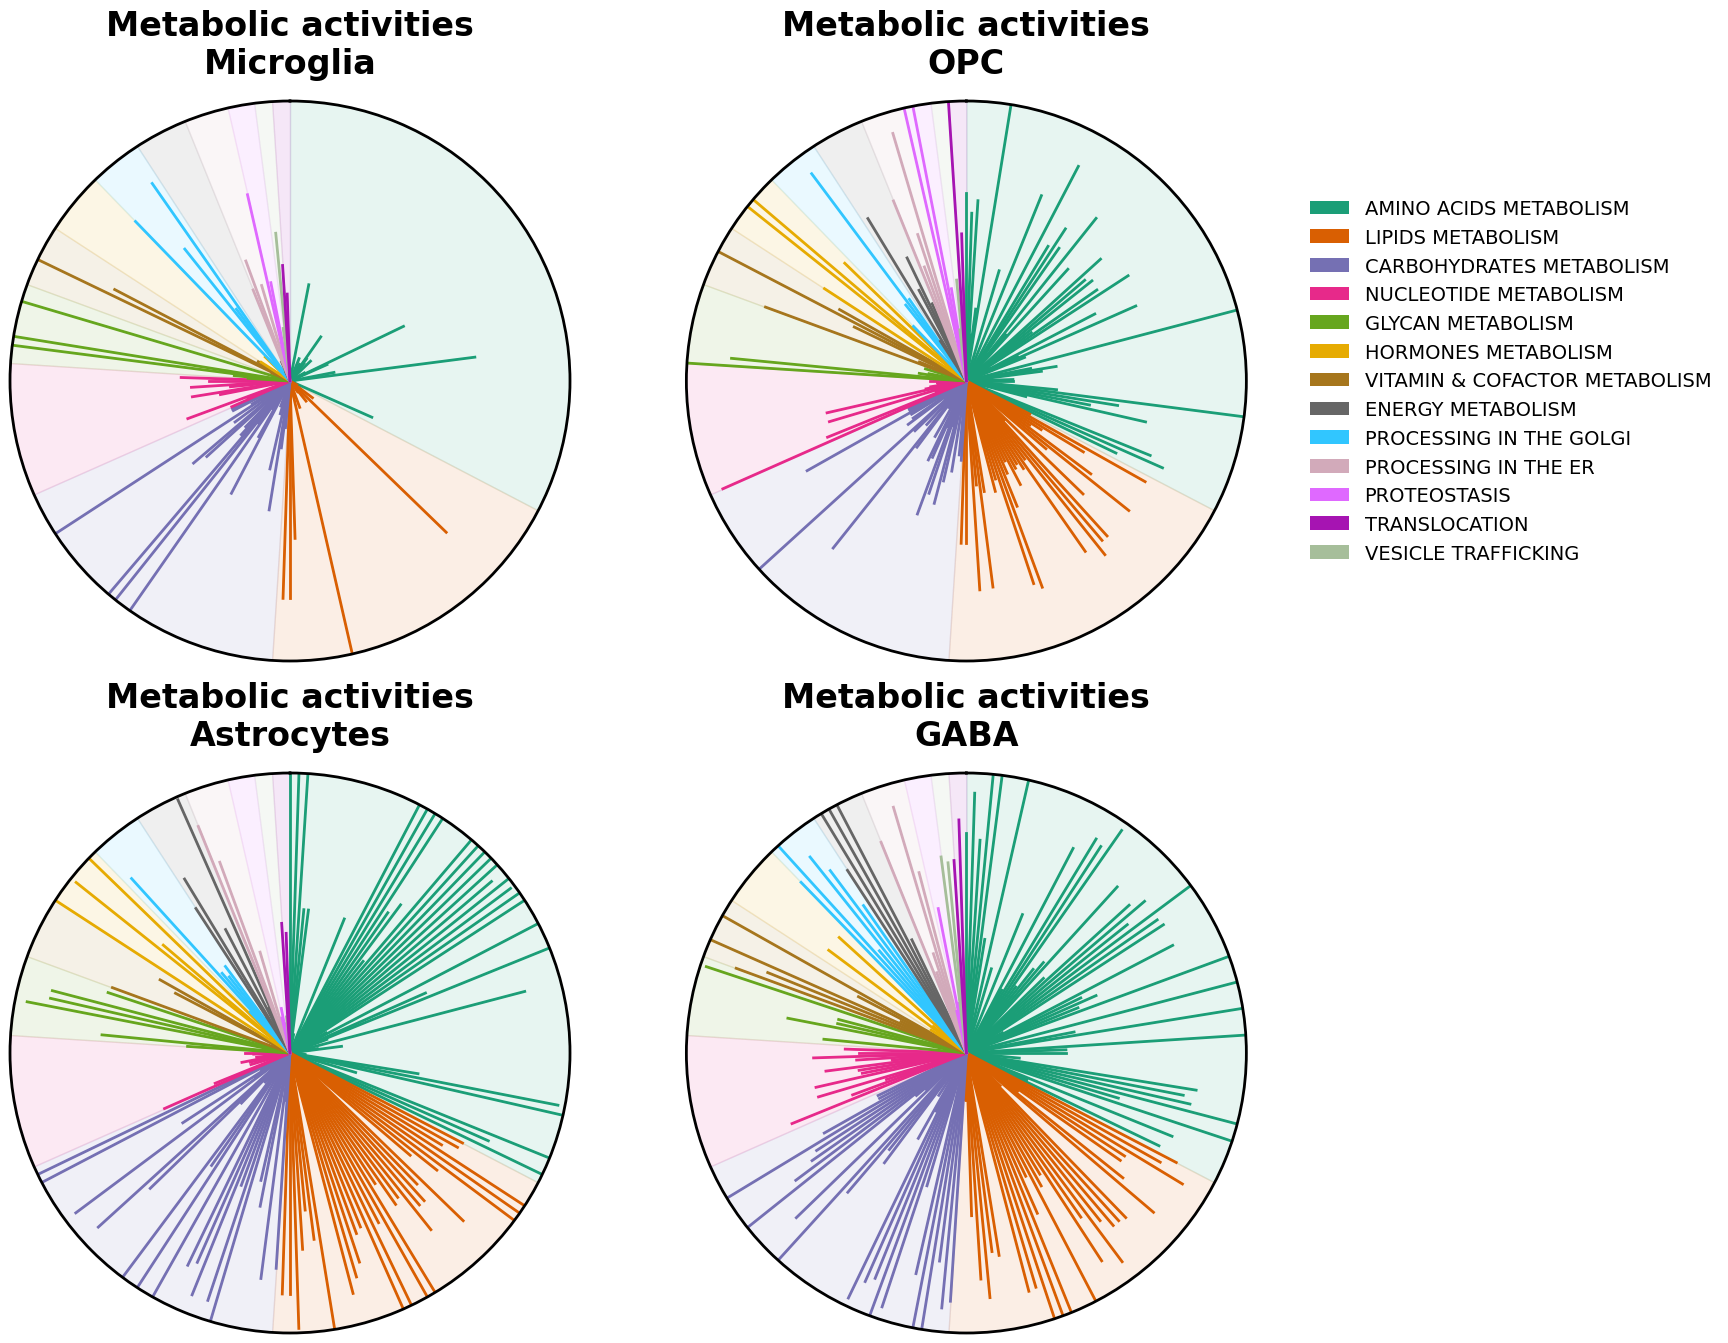

In [24]:
# Create figure with subplots
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221, projection='polar')
ax2 = fig.add_subplot(222, projection='polar')
ax3 = fig.add_subplot(223, projection='polar')
ax4 = fig.add_subplot(224, projection='polar')

for i, (cell, ax) in enumerate(zip(cell_types, [ax1, ax2, ax3, ax4])):
    sccellfie.plotting.create_radial_plot(df_melted, 
                                          results['task_info'],
                                          cell_type=cell,
                                          ax=ax,
                                          show_legend=i == 1,
                                          ylim=1.0
                                          )

Alternatively, we can sort tasks by their magnitude using ``sort_by_value=True``. 

<div class="alert alert-info">
<b>Note!</b>

When comparing cell types this will cause that a same metabolic tasks won't receive the same location in one cell type versus another, as each cell type will have a specific task order.

</div> 

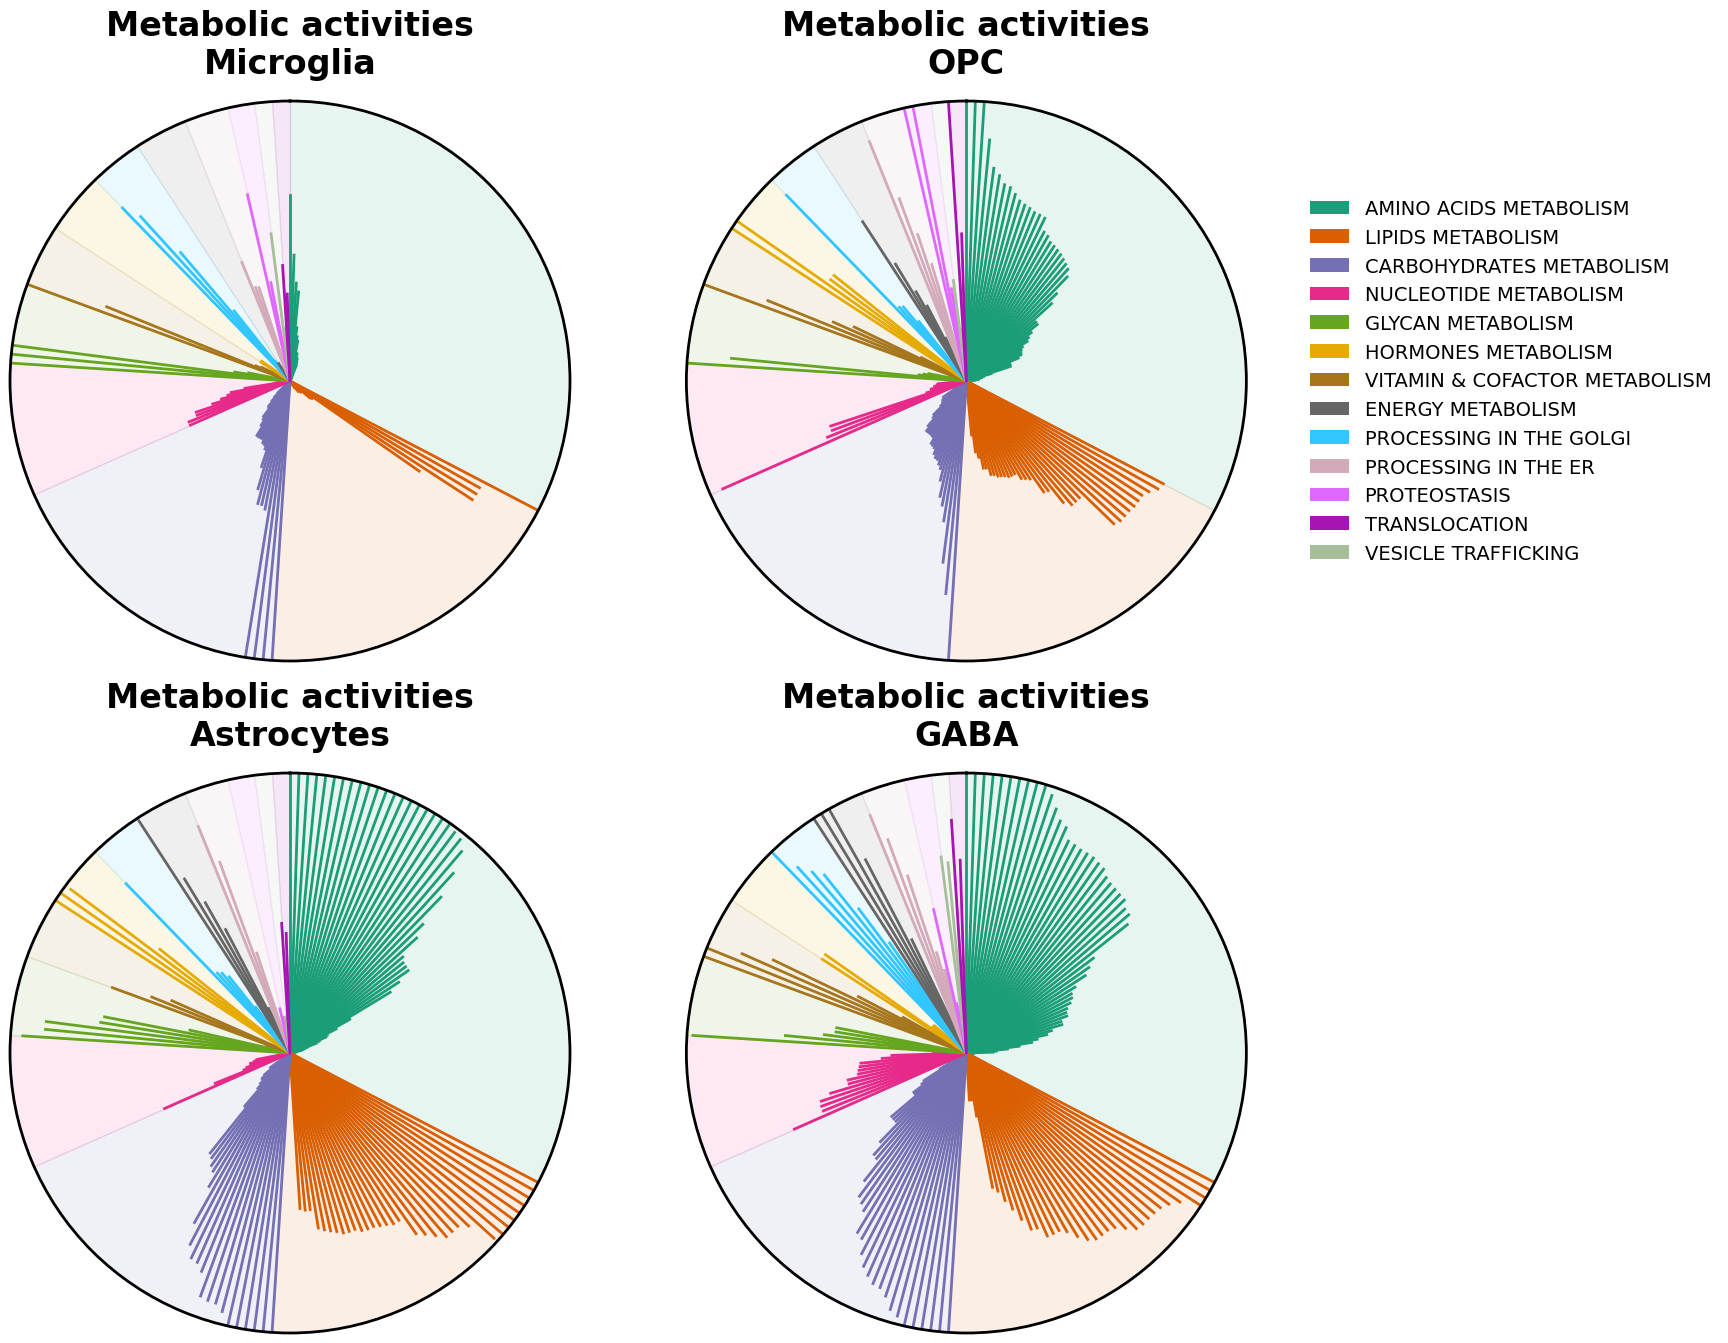

In [25]:
# Create figure with subplots
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221, projection='polar')
ax2 = fig.add_subplot(222, projection='polar')
ax3 = fig.add_subplot(223, projection='polar')
ax4 = fig.add_subplot(224, projection='polar')

for i, (cell, ax) in enumerate(zip(cell_types, [ax1, ax2, ax3, ax4])):
    sccellfie.plotting.create_radial_plot(df_melted, 
                                          results['task_info'],
                                          cell_type=cell,
                                          ax=ax,
                                          show_legend=i == 1,
                                          ylim=1.0,
                                          sort_by_value=True
                                          )

**For additional downstream analyses**, please visit our **Downstream Tutorials**. A good starting point is our **[General Overview Tutorial](https://sccellfie.readthedocs.io/en/latest/notebooks/extended_quick_start.html)**, which will get you started with some downstream analyses.